# Previsões para colheitas de 2020 via Regressão Logística One-vs-Rest e SMOTE
### Renato Júnior Moreira e Silva

Neste pequeno projeto*, utilizei os datasets disponibilizados pela empresa Scicrop para realizar a previsão de saúde/qualidade de colheitas em safras de 2020 utilizando uma classificação em 3 classes:

0 - Colheita Saudável

1 - Colheita sofreu danos por motivos diversos

2 - Colheita sofreu dano por pesticidas

A estratégia utilizada foi a de tomar uma regressão logística multiclasse via one-vs-rest e o principal obstáculo foi a de exemplos desbalanceados e utilizei o algoritmo SMOTE para sintetizar novos exemplos de classes minoritarias.

\* Projeto realizado como parte de um processo seletivo da Scicrop

## Lendo e limpando as Tabelas das Safras de 2018-2019, 2020


In [355]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
import matplotlib.pyplot as plt 
plt.rc("font", size=14)
from sklearn.model_selection import train_test_split
import seaborn as sns
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)

#Primeiramente, vamos ler a Safra de Treino e retirar os missing values da tabela
safra_treino=pd.read_csv("Safra_2018-2019.csv")
safra_treino=safra_treino.dropna()

#Agora, vamos ler a Safra para previsão:
safra_prev=pd.read_csv("Safra_2020.csv")
safra_prev=safra_prev.dropna()

In [356]:
#Vamos conhecer um pouco do formato e da tabela de dados:

print(safra_treino.shape)
safra_treino.head()

(71945, 11)


,Unnamed: 0,Identificador_Agricultor,Estimativa_de_Insetos,Tipo_de_Cultivo,Tipo_de_Solo,Categoria_Pesticida,Doses_Semana,Semanas_Utilizando,Semanas_Sem_Uso,Temporada,dano_na_plantacao
0,0,SCROP00001,188,1,0,1,0,0.0,0,1,0
1,1,SCROP00002,209,1,0,1,0,0.0,0,2,1
2,2,SCROP00003,257,1,0,1,0,0.0,0,2,1
3,3,SCROP00004,257,1,1,1,0,0.0,0,2,1
4,4,SCROP00005,342,1,0,1,0,0.0,0,2,1


## Visualizando os dados das safras e indexando os dataframes

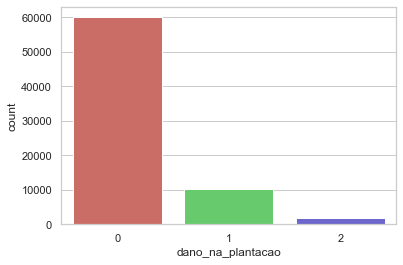

In [357]:
#Vamos explorar um pouco dos dados. Observemos a distribuição de resultados da colheita:
safra_treino['dano_na_plantacao'].value_counts()

#Plotamos também um gráfico ilustrando esta distribuição e vemos que há um nítido desbalanço
#na quantidade de colheitas saudáveis e colheitas não-saudáveis:
sns.countplot(x='dano_na_plantacao',data=safra_treino,palette='hls')
plt.show()

In [358]:
#Vamos restringir nosso dataframe aos dados que utilizaremos na regressão:
safra_treino=safra_treino.set_index('Identificador_Agricultor')
safra_treino=safra_treino.drop(columns=['Unnamed: 0'])

#Repetimos o feito acima para a safra de 2020:
safra_prev=safra_prev.set_index('Identificador_Agricultor')
safra_prev=safra_prev.drop(columns=['Unnamed: 0'])

## Resolvendo o problema de desbalanço de exemplos com SMOTE; dividindo os sets de treino e teste

In [359]:
#Vamos dividir nosso training set. Primeiramente, definimos X e y:
X = safra_treino.loc[:, safra_treino.columns != 'dano_na_plantacao']
y = safra_treino.loc[:, safra_treino.columns == 'dano_na_plantacao']

#Agora, utilizaremos o SMOTE para consertar o desbalanço entre os exemplos de treino.
from imblearn import under_sampling, over_sampling
from imblearn.over_sampling import SMOTE

bal=SMOTE(random_state=2)
X_treino, X_teste, y_treino, y_teste = train_test_split(X, y, test_size=0.3, random_state=0)
columns = X_treino.columns

bal_X,bal_y = bal.fit_sample(X_treino, y_treino)
bal_X=pd.DataFrame(data=bal_X,columns=columns )
bal_y=pd.DataFrame(data=bal_y,columns=['dano_na_plantacao'])

#Checamos o balanço feito nos dados de teste:
print("Quantidade de novos dados balanceados: ",len(bal_X))
print("Quantidade de colheitas saudáveis dentre os novos dados balanceados:",
      len(bal_y[bal_y['dano_na_plantacao']==0]))
print("Quantidade de colheitas com danos causados por outros motivos dentre os novos dados balanceados:",
      len(bal_y[bal_y['dano_na_plantacao']==1]))
print("Quantidade de colheitas com danos causados por inseticidas dentre os novos dados balanceados:",
      len(bal_y[bal_y['dano_na_plantacao']==2]))

Quantidade de novos dados balanceados:  125934
Quantidade de colheitas saudáveis dentre os novos dados balanceados: 41978
Quantidade de colheitas com danos causados por outros motivos dentre os novos dados balanceados: 41978
Quantidade de colheitas com danos causados por inseticidas dentre os novos dados balanceados: 41978


## Aplicando o algoritmo de Regressão Logística One-vs-Rest e estudando acurácia, confusion matrix e os scores F_1 para multiclasses

In [360]:
#Aplicamos regressão logística usando o algoritmo One-vs-rest:
from sklearn.linear_model import LogisticRegression

modelo = LogisticRegression(max_iter=1000,multi_class='ovr')
modelo.fit(bal_X, bal_y.values.ravel())

LogisticRegression(max_iter=1000, multi_class='ovr')

In [361]:
y_pred = modelo.predict(X_teste)
print('A acurácia do algoritmo de regressão logística multiclasses no set de teste é: {:.2f}'
      .format(modelo.score(X_teste, y_teste)))

A acurácia do algoritmo de regressão logística multiclasses no set de teste é: 0.66


In [362]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_teste, y_pred)
print(confusion_matrix)

[[13349  1797  2875]
 [ 1384   542  1097]
 [  219    59   262]]


In [363]:
from sklearn.metrics import f1_score
f1w=f1_score(y_teste,y_pred,average='weighted')
f1m=f1_score(y_teste,y_pred,average='micro')
print('Os F_1-Score weighted e micro são, respectivamente, {:.2f} e {:.2f}'.format(f1w,f1m))

Os F_1-Score weighted e micro são, respectivamente, 0.71 e 0.66


Concluímos que o algoritmo construído possui razoável efetividade para previsões.

## Realizando as previsões para a safra de 2020 e visualizando os dados

In [364]:
#Finalmente, calculamos as previsões para a safra de 2020
prev_2020=modelo.predict(safra_prev)
previsoes=safra_prev
previsoes['dano_na_plantacao']=prev_2020

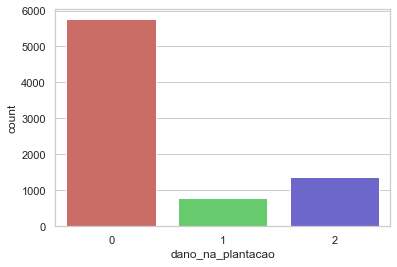

In [365]:
#Podemos visualizar os dados desta previsão:
previsoes['dano_na_plantacao'].value_counts()

sns.countplot(x='dano_na_plantacao',data=previsoes,palette='hls')
plt.show()

In [366]:
#O resultado da previsão do algoritmo construído é:

print('As previsões para a Safra de 2020 utilizando uma regressão logística multiclasses'
      ' com correção de desbalanços via SMOTE sugerem que em 2020, {} colheitas estarão saudáveis,' 
      '{} colheitas sofrerão danos gerados pelos pesticidas e {} colheitas sofrerão danos por outros motivos'
      .format(len(previsoes[previsoes['dano_na_plantacao']==0]),
              len(previsoes[previsoes['dano_na_plantacao']==2]),
              len(previsoes[previsoes['dano_na_plantacao']==1])))

As previsões para a Safra de 2020 utilizando uma regressão logística multiclasses com correção de desbalanços via SMOTE sugerem que em 2020, 5760 colheitas estarão saudáveis,1357 colheitas sofrerão danos gerados pelos pesticidas e 796 colheitas sofrerão danos por outros motivos


Em outras palavras, 10% das colheitas sofrerá danos por motivos diversos, cerca de 17% das colheitas sofrerá danos por uso de pesticidas e cerca de 73% das colheitas estará saudável.